In [1]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [2]:
import pandas as pd
#Pipline Imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.cloud import storage
from PIL import Image
import io
import os
import numpy as np

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2025-06-09 09:49:23.383524: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 09:49:23.402736: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 09:49:23.550625: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 09:49:23.706801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749458963.801290   12090 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749458963.83

In [53]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout

In [6]:
import sys
import os

# Add parent directory to Python path
sys.path.append(os.path.abspath("../skin_scan"))

# Now you can import the module
import preprocessing
from data import get_metadata_from_bq

In [8]:
metadata = get_metadata_from_bq()
metadata.shape

(10015, 8)

In [9]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,index
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,4349
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,4263
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,4217
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,3587
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,1451


In [67]:
metadata.dx.value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [11]:
# Split into nv and non-nv rows
nv_rows = metadata[metadata['dx'] == 'nv']
non_nv_rows = metadata[metadata['dx'] != 'nv']

# Drop duplicates from nv rows based on lesion_id (keeping the first occurrence)
nv_deduped = nv_rows.drop_duplicates(subset='lesion_id', keep='first')

In [12]:
non_nv_rows.shape

(3310, 8)

In [13]:
nv_rows.shape

(6705, 8)

In [14]:
shuffled_nv_rows = nv_rows.sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
nv_rows_small = shuffled_nv_rows.iloc[:3600]

In [16]:
metadata_cleaned = pd.concat([nv_rows_small, non_nv_rows], ignore_index=True)

In [17]:
metadata_cleaned.shape

(6910, 8)

In [18]:
processed_metadata = preprocessing.preprocess_metadata(metadata_cleaned)

In [19]:
processed_metadata.shape

(6766, 6)

In [20]:
processed_metadata_small = processed_metadata

In [22]:
processed_metadata_small.reset_index(drop=True,inplace=True)

In [23]:
processed_metadata_small

,image_id,dx,age,sex,localization,index
0,ISIC_0024306,nv,45.0,male,trunk,4349
1,ISIC_0024310,mel,60.0,male,chest,1451
2,ISIC_0024312,bkl,75.0,male,lower extremity,700
3,ISIC_0024313,mel,50.0,female,back,2130
4,ISIC_0024315,mel,55.0,male,trunk,1327
...,...,...,...,...,...,...
6761,ISIC_0034316,mel,85.0,male,upper extremity,1721
6762,ISIC_0034317,mel,70.0,female,lower extremity,1888
6763,ISIC_0034318,bkl,55.0,male,trunk,121
6764,ISIC_0034319,nv,30.0,male,trunk,7440


In [24]:
client = storage.Client()
bucket = client.bucket("skin_scan_mohnatz")
blobs = bucket.list_blobs(prefix="train_all_images/")
images = [blob.name for blob in blobs if blob.name.lower().endswith(".jpg")]

In [25]:
resized_array = []

In [26]:
for name in processed_metadata_small.image_id:
    for image in images:
        if image.endswith(f"{name}.jpg"):
            blob = bucket.blob(image)
            image_bytes = blob.download_as_bytes()
            img = Image.open(io.BytesIO(image_bytes))
            img = img.resize((96, 96))
            resized_array.append(np.array(img))

In [27]:
X_images = np.array(resized_array)

In [28]:
X_images.shape

(6766, 96, 96, 3)

In [29]:
X_images_copy = X_images.copy()

In [30]:
X_images = X_images/255

In [31]:
processed_metadata_small

,image_id,dx,age,sex,localization,index
0,ISIC_0024306,nv,45.0,male,trunk,4349
1,ISIC_0024310,mel,60.0,male,chest,1451
2,ISIC_0024312,bkl,75.0,male,lower extremity,700
3,ISIC_0024313,mel,50.0,female,back,2130
4,ISIC_0024315,mel,55.0,male,trunk,1327
...,...,...,...,...,...,...
6761,ISIC_0034316,mel,85.0,male,upper extremity,1721
6762,ISIC_0034317,mel,70.0,female,lower extremity,1888
6763,ISIC_0034318,bkl,55.0,male,trunk,121
6764,ISIC_0034319,nv,30.0,male,trunk,7440


In [32]:
processed_metadata_small.dx.value_counts(normalize=False)

dx
nv       3494
mel      1103
bkl      1076
bcc       509
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [33]:
round(processed_metadata_small.dx.value_counts(normalize=True)*100,1)

dx
nv       51.6
mel      16.3
bkl      15.9
bcc       7.5
akiec     4.8
vasc      2.1
df        1.7
Name: proportion, dtype: float64

In [34]:
X_metadata, y, preprocessor, class_names = preprocessing.prepare_data_for_model(processed_metadata_small)

In [35]:
X_metadata.shape

(6766, 15)

In [37]:
X_images.shape

(6766, 96, 96, 3)

In [38]:
y.shape

(6766, 7)

## Model

In [54]:
# Image Branch
image_input = Input(shape=(96, 96, 3))
cnn = Conv2D(16, (6, 6), activation='relu')(image_input)
cnn = Dropout(0.2)(cnn)  # Dropout after first Conv2D

cnn = Conv2D(32, (3, 3), activation='relu')(cnn)
cnn = Dropout(0.3)(cnn)  # Dropout after second Conv2D

cnn = Flatten()(cnn)
cnn = Dense(64, activation='relu')(cnn)
cnn = Dropout(0.5)(cnn)  # Dropout after Dense
cnn = Dense(32, activation='relu')(cnn)

# Metadata Branch
meta_input = Input(shape=(15,))
dln = Dense(16, activation='relu')(meta_input)
dln = Dropout(0.3)(dln)

# Combined Final Layers
combined_layers = concatenate([cnn, dln])
x = Dense(32, activation='relu')(combined_layers)
output = Dense(7, activation='softmax')(x)

# Define Model
test_model = Model(inputs=[image_input, meta_input], outputs=output)

In [55]:
test_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy","recall"])

In [56]:
test_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 91, 91,    │      1,744 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 91, 91,    │          0 │ conv2d_3[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 89, 89,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 89, 89,    │          0 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 253472)    │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │ 16,222,272 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        256 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 48)        │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      1,568 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 7)         │        231 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,232,791 (61.92 MB)

 Trainable params: 16,232,791 (61.92 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
es = EarlyStopping(patience=10, restore_best_weights=True)

In [58]:
X_images.shape

(6766, 96, 96, 3)

In [59]:
X_metadata.shape

(6766, 15)

In [60]:
X_images_train, X_images_test, X_metadata_train, X_metadata_test, y_train, y_test = train_test_split(
    X_images, X_metadata, y, test_size=0.3, random_state=42
)

In [61]:
X_images_train.shape

(4736, 96, 96, 3)

In [62]:
X_metadata_train.shape

(4736, 15)

In [63]:
y_train.shape

(4736, 7)

In [64]:
history = test_model.fit([X_images_train, X_metadata_train], y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[es])

Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.4622 - loss: 2.1478 - recall: 0.2049 - val_accuracy: 0.4989 - val_loss: 1.3665 - val_recall: 0.2268
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.5050 - loss: 1.3214 - recall: 0.2904 - val_accuracy: 0.5274 - val_loss: 1.2942 - val_recall: 0.2215
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.5344 - loss: 1.2530 - recall: 0.3348 - val_accuracy: 0.5622 - val_loss: 1.2285 - val_recall: 0.2595
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.5689 - loss: 1.2106 - recall: 0.3329 - val_accuracy: 0.5728 - val_loss: 1.1701 - val_recall: 0.3207
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.5735 - loss: 1.1672 - recall: 0.3772 - val_accuracy: 0.5728 - val_loss: 1.1705 - val_recall: 0.3122
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.5755 - loss: 1.1668 - recall: 0.3934 - val_accuracy: 0.5854 - val_loss: 1.1570 -

In [65]:
test_model.evaluate([X_images_test,X_metadata_test],y_test)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6570 - loss: 0.9048 - recall: 0.5355


[0.9083866477012634, 0.6561576128005981, 0.5364531874656677]

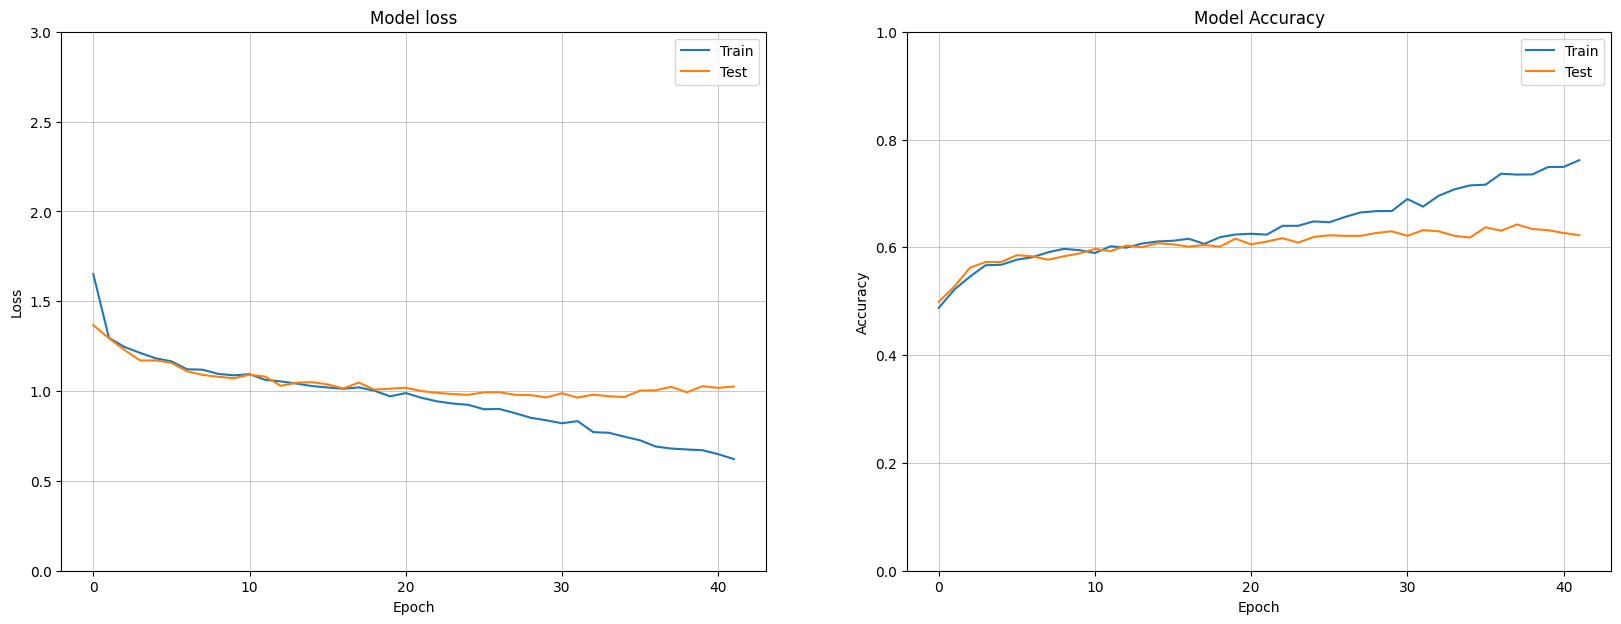

In [66]:
plot_loss_accuracy(history)